# CmpE 482 - Final Projects
### Ahmet Ercan Tekden

## Project 1 - Interpolatation with Autoregressive(AR) models


### Step 1 
Read the flights.csv file into two column vectors T and X, where X is partially observed monthly totals of international airline passengers and T is the corresponding months.

Plot T vs. X

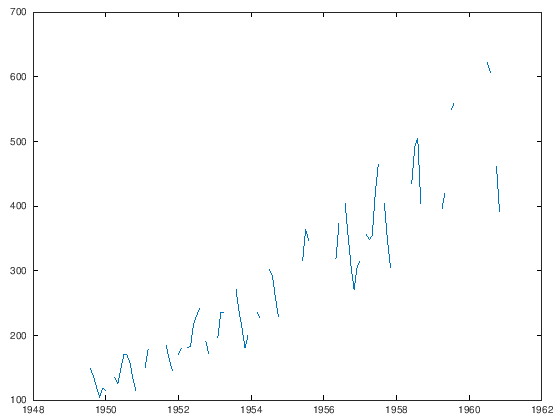

In [104]:
filename = 'flights.csv';
delimiterIn = ',';
Data = importdata(filename,delimiterIn);
T= Data.data(:,1);
X= Data.data(:,2);

plot(T,X)

### Settings

In [180]:
Unknown_x_indices = find(isnan(X));
M= 4;
N=length(X);
GX=zeros(N-M,M);
GA=zeros(N-M,N);

### Iteration Part

In [201]:
X_temp=X;
X_temp(Unknown_x_indices)=0;
for i=1:1000
    %% Setting X_obs 
    X_obs=X_temp;
    X_obs(Unknown_x_indices)=0;

    %% Setting Gx and finding A.

    for i=1:N-M
        GX(i,:)=fliplr(X_temp(i:i+M-1)');
    end
    
    %% Solving A with QR
    [QGX RGX] = qr(GX);
    A= (RGX)\(QGX'*X_temp(M+1:end));  
    
    %% Setting Ga
    for i=1:N-M
        GA(i,i:i+M)=[A' -1];
    end
    
    %% Solve for X_mi
    % If we think equation as Ax=b
    % A,x,b becomes A=GA(X_mi indexes),x=X_mi b=-GA*X_obs
    [QGA RGA] = qr(GA(:,Unknown_x_indices));
    % We can directly write -GA * X_obs because X_mi corresponding indexes of b will become 0 after multiplication.
    b = (-GA* X_obs);
    X_mi= (RGA)\(QGA'*b);
    X_temp(Unknown_x_indices)=X_mi; %% Update indexes of X_mi
end

X_new = X_temp;


### Plots

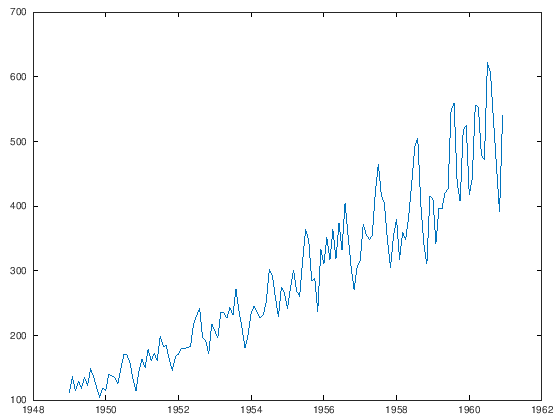

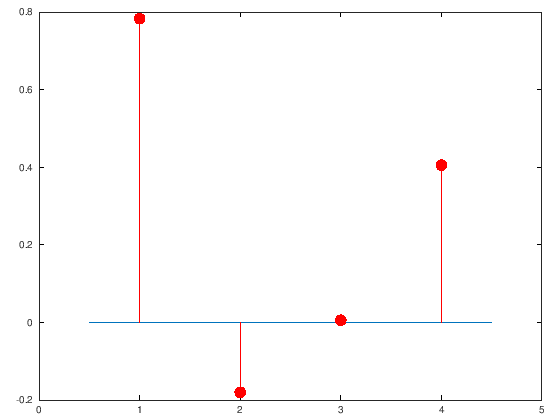

In [245]:
%% Plot T with X
plot(T,X_temp);

%% Plot A with reference line on X axis.
figure;
plot([0.5,4.5],[0,0]);
hold on;
scatter([1:4],A,1000,'r','filled');
hold on;
for i=1:4
    plot([i,i],[0,A(i)],'r');
    hold on;
end

# Project 2